In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import unicodedata
import urlextract
import spacy
import regex
import nltk
import re

In [2]:
!python -m spacy download pt

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
  Using cached pt_core_news_sm-2.3.0-py3-none-any.whl
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/home/lorenzovaralo/anaconda3/envs/ML/lib/python3.7/site-packages/pt_core_news_sm
-->
/home/lorenzovaralo/anaconda3/envs/ML/lib/python3.7/site-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [3]:
nltk.download('punkt')
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('portuguese')
sw.remove('sem')
sw.remove('nem')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/lorenzovaralo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lorenzovaralo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('Dataframe.csv')

In [5]:
desc = df.addesc
desc

0        "CARRO EM EXCELENTE ESTADO TUDO FUNCIONANDO.&l...
1        "JEEP COMPASS LONGITUDE TD350 DIESEL!&lt;br&gt...
2        "FIAT TORO VOLCANO DIESEL 4X4 !&lt;br&gt;COMPL...
3                         "Carro em ótimo estado, 2 dono."
4        "Whatsapp - (51) 99359.1000&lt;br&gt;&lt;br&gt...
                               ...                        
23751    "Vendo Voyage 93 bem conservado.. &lt;br&gt;Ma...
23752    "Montana LS2 Versão completa com &lt;br&gt;Ar-...
23753    "Vendo Fluence Dyn. Plus, completo, motor 2.0 ...
23754    "81 mil km trocado pastilha revisado bomba lim...
23755    "? 4x4 &lt;br&gt;? rodas 20 com pneus novos &l...
Name: addesc, Length: 23756, dtype: object

In [6]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     /home/lorenzovaralo/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [7]:
from nltk.stem import RSLPStemmer
stemmer = RSLPStemmer()
pattern = regex.compile(r'[^\p{L}]+', re.UNICODE)

def normalize_chars(texto):
    texto = texto.lower()
    texto = texto.replace('&lt;', ' ').replace('br&gt;', ' ')
    tokens = nltk.tokenize.word_tokenize(texto, language='portuguese', )
    texto =  ' '.join([stemmer.stem(x) for x in tokens if x not in sw])
    #texto = ''.join(char for char in unicodedata.normalize('NFD', texto) if unicodedata.category(char) != 'Mn')
    texto = re.sub('4\s?x\s?4', ' QUATROPORQUATRO ', texto)
    texto = re.sub('[3-9]\d\d\d.?\d\d\d\d', ' NUMTELEFONE ', texto)
    texto = re.sub('w(ha|a).+?\s', ' WHATS ', texto)
    texto = re.sub('www\..+?(\.com\.br|\.com)', ' URL ', texto)
    texto = pattern.sub(' ', texto)
    return re.sub('\s+', ' ', texto).strip()

In [8]:
desc = desc.apply(normalize_chars)
desc

0        carr excel est tud funcion carr complet inform...
1        jeep compas longitud td diesel complet multimi...
2        fiat tor volc diesel QUATROPORQUATRO complet s...
3                                        carr ótim est don
4        WHATS NUMTELEFONE gravataí NUMTELEFONE opç zer...
                               ...                        
23751    vend voyag bem conserv fot inform cham WHATS N...
23752    mont ls vers complet ar condicion direç hidráu...
23753    vend fluenc dyn plu complet motor gnv carr top...
23754    mil km troc pastilh revis bomb limp flu arrefe...
23755    QUATROPORQUATRO rod pneu nov banc cour nov fei...
Name: addesc, Length: 23756, dtype: object

In [9]:
desc.iloc[0]

'carr excel est tud funcion carr complet inform WHATS xa xa public revend'

In [10]:
vectorizer = TfidfVectorizer(max_features=1000, strip_accents='unicode', dtype=np.float32)
Xa = vectorizer.fit_transform(desc).toarray()

In [11]:
vocab = vectorizer.get_feature_names()

In [12]:
desc

0        carr excel est tud funcion carr complet inform...
1        jeep compas longitud td diesel complet multimi...
2        fiat tor volc diesel QUATROPORQUATRO complet s...
3                                        carr ótim est don
4        WHATS NUMTELEFONE gravataí NUMTELEFONE opç zer...
                               ...                        
23751    vend voyag bem conserv fot inform cham WHATS N...
23752    mont ls vers complet ar condicion direç hidráu...
23753    vend fluenc dyn plu complet motor gnv carr top...
23754    mil km troc pastilh revis bomb limp flu arrefe...
23755    QUATROPORQUATRO rod pneu nov banc cour nov fei...
Name: addesc, Length: 23756, dtype: object

In [14]:
df = df[['gearbox','regdate','mileage','motorpower','fuel','car_steering','doors', 'price', 'valorFipe']]

In [15]:
df['pricewrtfipe'] = (df.loc[:,'price']/df.loc[:,'valorFipe'])
df.drop(['price','valorFipe'], axis='columns', inplace=True)

<AxesSubplot:>

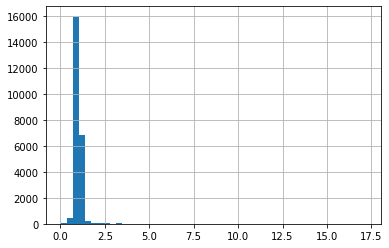

In [16]:
df.pricewrtfipe.hist(bins=50)

In [17]:
df.pricewrtfipe.std()

0.33518418818612455

In [18]:
def normalize_data2(df, gausify=True, std_scale=True):
    data = df.copy()
    m = data.__len__()
    if gausify:
        data['regdate'] = data.regdate.apply(lambda x: np.log1p(data.regdate.max() - x))
        data['mileage'] = data.mileage.apply(np.sqrt)
    
    if std_scale:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    scaled_data = scaler.fit_transform(data[['regdate','mileage','pricewrtfipe']].values.reshape((m,3)))
    data[['regdate','mileage','pricewrtfipe']] = scaled_data

    return data

In [19]:
df = pd.get_dummies(df)
df = normalize_data2(df)

<AxesSubplot:>

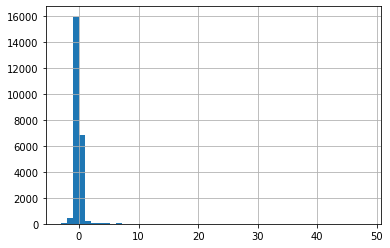

In [20]:
df.pricewrtfipe.hist(bins=50)

In [21]:
#words_df = words_df.loc[(ml.pricewrtfipe > -3.1)&(ml.pricewrtfipe < 3.1)]
#ml = ml.loc[(ml.pricewrtfipe > -3.1)&(ml.pricewrtfipe < 3.1)]
#ml.pricewrtfipe = StandardScaler().fit_transform(ml.pricewrtfipe.values.reshape(ml.__len__(), 1))

In [22]:
df.pricewrtfipe.mean()

-4.55828897667281e-16

<AxesSubplot:>

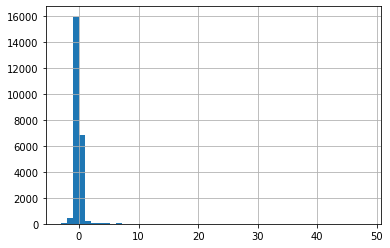

In [23]:
df.pricewrtfipe.hist(bins=50)

In [24]:
df_ww = pd.concat((df['pricewrtfipe'], df.drop('pricewrtfipe', axis='columns'), pd.DataFrame(Xa, columns=vocab)), axis=1)
del df
del Xa
del vocab
del desc

In [25]:
df_ww.to_csv('datanlp3.csv')

In [26]:
df_ww

,pricewrtfipe,regdate,mileage,doors,gearbox_Automático,gearbox_Manual,motorpower_1.0,motorpower_1.2,motorpower_1.3,motorpower_1.4,...,xf,xj,xkr,xl,xr,xs,xxx,zaf,zer,zon
0,-0.100900,0.565747,0.352588,1,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,-0.159984,-2.345612,-2.026409,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,-0.108632,-0.560521,-0.114044,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,-0.258163,0.565747,0.453117,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,-0.921772,0.695805,2.519195,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169866,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23751,-1.091563,2.107870,1.056981,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
23752,0.053888,-0.560521,-0.028144,0,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159703,0.0
23753,-0.506957,-0.310047,-2.026409,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
23754,-0.384117,0.269500,0.239411,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.326355,0.0


In [27]:
df_ww.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23756 entries, 0 to 23755
Columns: 1026 entries, pricewrtfipe to zon
dtypes: float32(1000), float64(3), int64(1), uint8(22)
memory usage: 91.8 MB


In [29]:
%whos

Variable                Type               Data/Info
----------------------------------------------------
CountVectorizer         type               <class 'sklearn.feature_e<...>on.text.CountVectorizer'>
ENGLISH_STOP_WORDS      frozenset          frozenset({'a', 'nobody',<...>, 'on', 'over', 'often'})
HashingVectorizer       type               <class 'sklearn.feature_e<...>.text.HashingVectorizer'>
MinMaxScaler            type               <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
RSLPStemmer             ABCMeta            <class 'nltk.stem.rslp.RSLPStemmer'>
StandardScaler          type               <class 'sklearn.preproces<...>ng._data.StandardScaler'>
TfidfTransformer        type               <class 'sklearn.feature_e<...>n.text.TfidfTransformer'>
TfidfVectorizer         type               <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
builtins                module             <module 'builtins' (built-in)>
cross_validate          function           <fun